In [1]:
'''
Objective: 
    Regression of median housing prices in CA
Data: 
    Comes from 1997 paper titled Sparse Spatial Autoregressions by Pace, 
    R. Kelley and Ronald Barry, published in the Statistics and Probability
    Letters journal. They built it using the 1990 California census data. 
    It contains one row per census block group. A block group is the 
    smallest geographical unit for which the U.S. Census Bureau publishes 
    sample data (a block group typically has a population of 600 to 3,000 people).

    Data is hosted on a github account for the author of the O'Reilly book 
    'Hands-on Machine Learning with Scikit-Learn and TensorFlow'

Notes:
    Task is to display an end to end project that performs 
    1) collect and clean data in an automated fashion
    2) data exploration and test engineered features for usefulness
    3) prep data for ingestion for ML models via pipelines
    4) test models with K fold CV testing and use ensemble learning
    5) evaluate performance on test set (hold out set)
'''

# getting the data pkgs
import os
import tarfile
from six.moves import urllib

In [2]:
# location of the dataset and will extract to ~/datasets/housing/
DATASETS_ROOT = os.path.join(os.path.expanduser('~'),"datasets")
DOWNLOAD_ROOT = "https://github.com/ageron/handson-ml/blob/master/"
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz?raw=true"

In [3]:
# automate the fetching of the dataset via tarball extraction
# slight modification from the text example to make this more
# generalizable for consuming generic tarballs for resusable code
def fetch_tarball_data(data_url = None, data_root_path = None):
    if data_url is None:
        print 'no data_url provided'
        return None
    
    if data_root_path is None:
        print 'no data_root_path is provided'
        return None
    
    if not os.path.isdir(data_root_path):
        print str(data_root_path) + ' does not exist => making dir...'
        #os.makedirs(data_root_path)
        print 'dir made.'
        
    #check the format of the file path in the url        
    tgz_pos = data_url.rfind('.tgz')
    tgz_add = len('.tgz')
    if tgz_pos == -1:
        tgz_pos = data_url.rfind('.tar.gz')
        tgz_add = len('.tar.gz')
    
    if tgz_pos == -1:
        print 'url not properly formated as a .tgz or .tgr.gz'
        return None 
    
    #looking for the /XXX.tgzYYY string
    file_name_pos = data_url.rfind('/')+1
    if file_name_pos == 0:
        print 'url not properly formated as a .tgz or .tgr.gz'
        return None
    else:    
        file_name = data_url[file_name_pos:(tgz_pos+tgz_add)]
        dir_name = data_url[file_name_pos:tgz_pos]
        
    # now create the directory to store and extract the tgz
    dataset_path = os.path.join(data_root_path,dir_name)
    
    if not os.path.isdir(dataset_path):
        print str(dataset_path) + ' does not exist => making dir...'
        os.makedirs(dataset_path)
        print 'dir made.'
    
    # now to download the file...
    tgz_path = os.path.join(dataset_path, file_name)
    print "requesting "+ data_url
    urllib.request.urlretrieve(data_url,tgz_path)
    print "recieved."
    print "extracting to" + dataset_path
    
    # extract the tarball
    if tarfile.is_tarfile(tgz_path):
        data_tgz = tarfile.open(tgz_path)
        data_tgz.extractall(path=dataset_path)
        data_tgz.close()
    else:
        print 'recieved file not detected as tarball...need to check source'
        
    print "done."
    
    # return extracted file names
    files = [ 
             os.path.join(dataset_path,file) for file in os.listdir(dataset_path) 
                 if (file[0] != '.') and ('.tgz' not in file) and ('.tar.gz' not in file)
            ]

    return files

In [4]:
extracted_files = fetch_tarball_data(data_url=HOUSING_URL, data_root_path=DATASETS_ROOT)

requesting https://github.com/ageron/handson-ml/blob/master/datasets/housing/housing.tgz?raw=true
recieved.
extracting to/Users/bvlcek/datasets/housing
done.


In [5]:
print(extracted_files)

['/Users/bvlcek/datasets/housing/housing.csv']


In [6]:
# START OF THE DATA EXPLORATION STEP
import pandas as pd

In [7]:
housing = pd.read_csv(extracted_files[0])

In [8]:
# check it imported into a dataframe okay...
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [9]:
housing.shape

(20640, 10)

In [10]:
#what kind of data are we dealing with?
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [11]:
housing.columns

Index([u'longitude', u'latitude', u'housing_median_age', u'total_rooms',
       u'total_bedrooms', u'population', u'households', u'median_income',
       u'median_house_value', u'ocean_proximity'],
      dtype='object')

In [12]:
# descriptive stats on numerical features
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [13]:
# counts for our only categorical feature
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

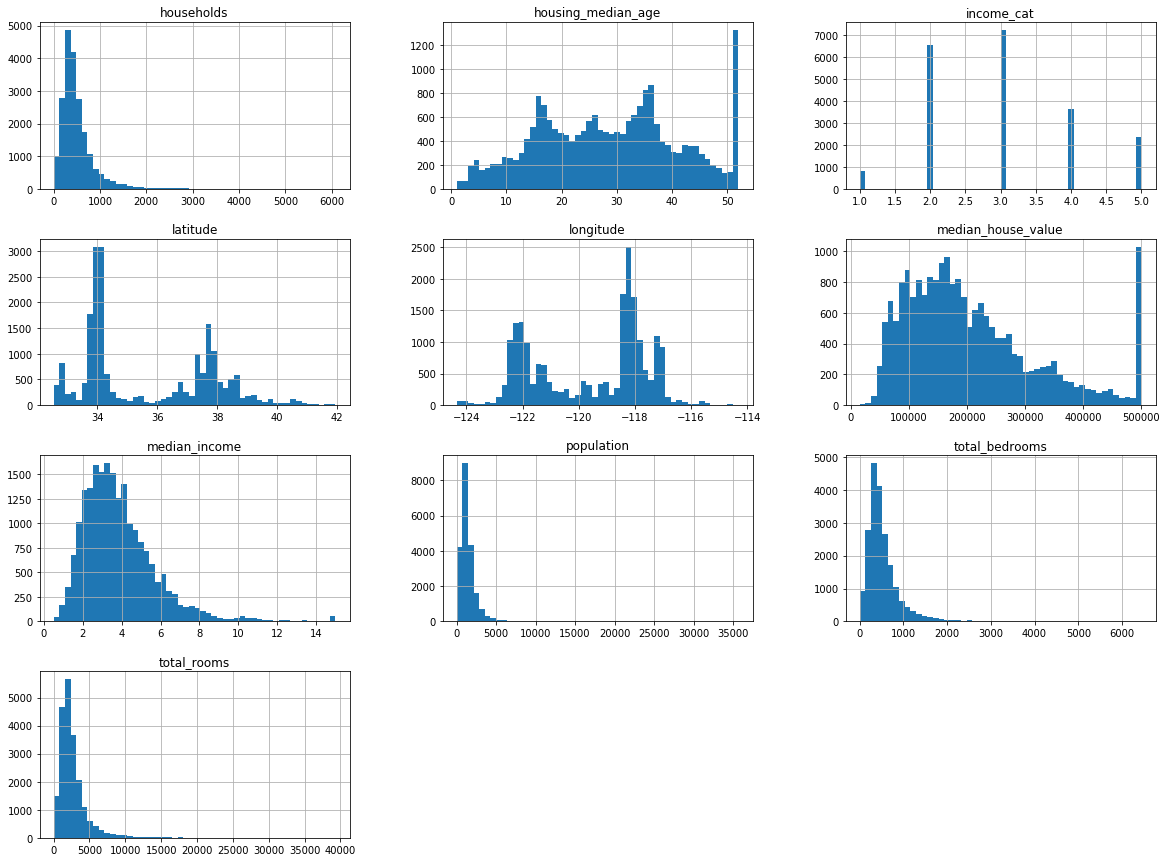

In [35]:
# visualize the data through histograms
import matplotlib.pyplot as plt
%matplotlib inline

housing.hist(bins=50,figsize=(20,15))
plt.show()

In [ ]:
# looks like we've got some sort of cap or aggregated bin in median_house_value
# and in housing_median_age, where anything above a fixed value is brought back into
# the final bin... or they could be samples from a different pop. Unknown, would have 
# to consult the creator of the data for the answer if they did impose a cut off.  
# Distributions look bi-modal on locations probabaly SF and southern CA, and others 
# look like Poisson or exponential decays.

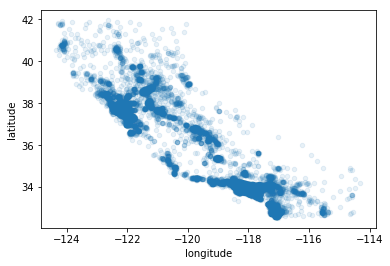

In [91]:
# lets make a scratch set for use in making visualizations
visual_set = strat_train_set.copy()

# lets visualize the long and lats for all these homes, see where they are...
visual_set.plot(kind='scatter',x='longitude',y='latitude',alpha = 0.1)
plt.show()

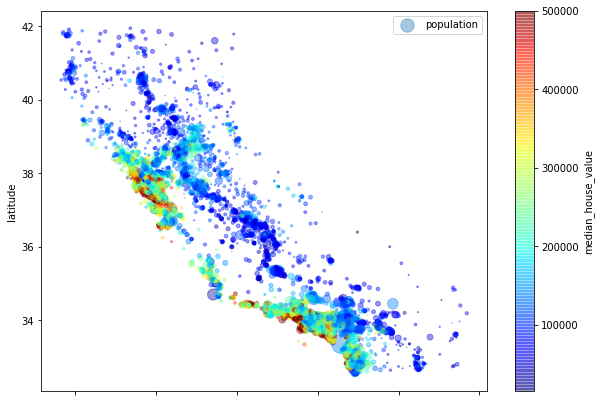

In [92]:
# more advanced visualization with the point sized by the population
# feature
visual_set.plot(kind='scatter',x='longitude',y='latitude',alpha = 0.4,
               s=visual_set['population']/100., label='population', figsize=(10,7),
               c='median_house_value',cmap=plt.get_cmap('jet'),colorbar=True)

plt.legend()
plt.show()

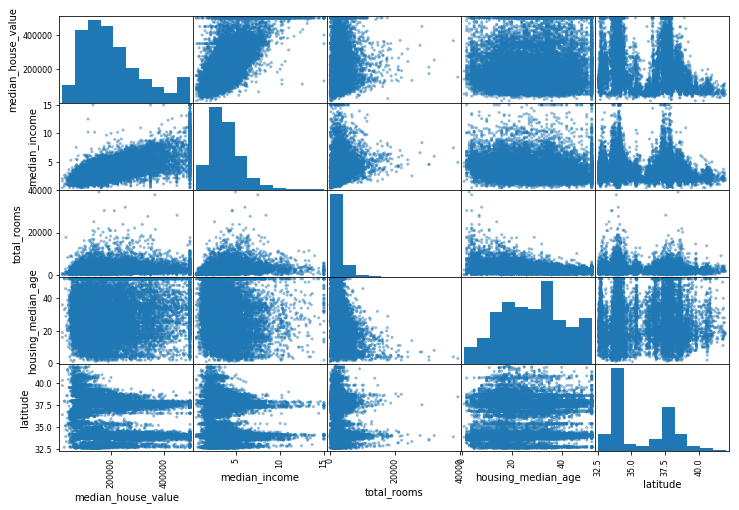

In [93]:
# no suprises there...

# lets start to explore relationships
from pandas.plotting import scatter_matrix

# now we dont want to plot all of the features against each other
# lets just select the most promising features based on their col
# names...
attr_of_interest = ['median_house_value','median_income','total_rooms','housing_median_age','latitude']
scatter_matrix(visual_set[attr_of_interest], figsize=(12,8))
plt.show()

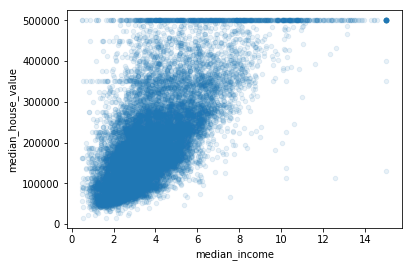

In [94]:
# the strongest relationship seems to be between lat and median_income
# which probably is just an indication of those in southern cali
# are going to be making a lot more money than those in the north
visual_set.plot(kind='scatter',x='median_income',y='median_house_value',alpha=0.1)
plt.show()

In [98]:
# let's try out a little feature engineering, see
# if they have strong relationships between other
# vars...
visual_set['rooms_per_household'] = visual_set['total_rooms']/visual_set['households']
visual_set['bedrooms_per_room'] = visual_set['total_bedrooms'] / visual_set['total_rooms']

# this one seems like a supply and demand type feature
# I would expect it to be very useful...
visual_set['population_per_household'] = visual_set['population']/visual_set['households']

In [99]:
# lets see how useful they are with the target var
corr_matrix = visual_set.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

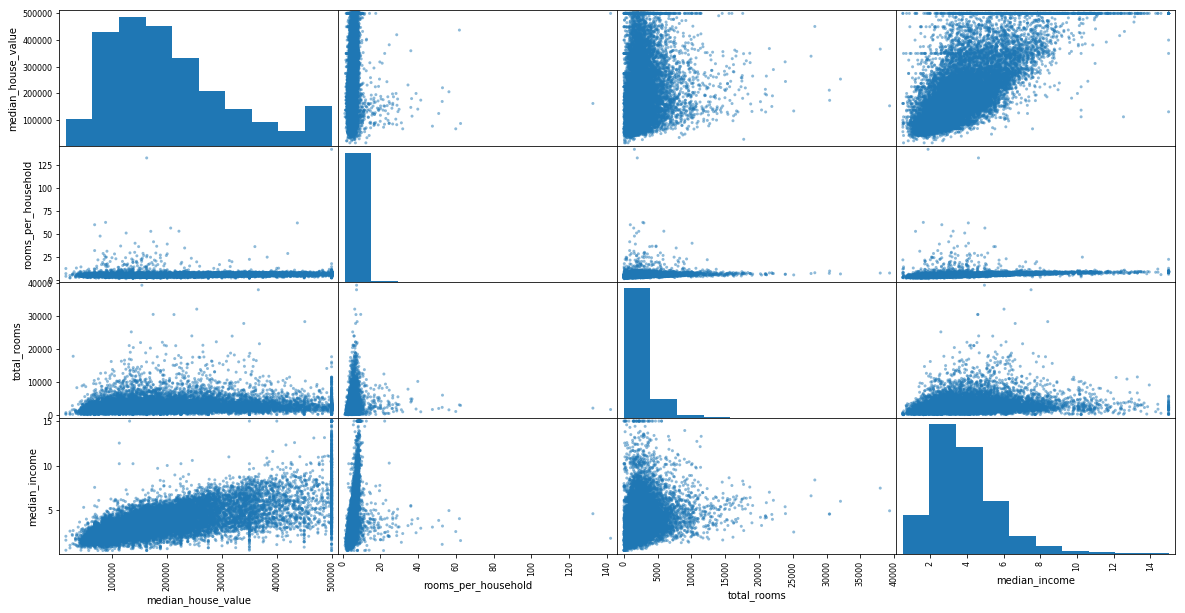

In [100]:
# damn pop per house isnt a very strong indicator (at least no linear relationship)
# not bad correlations for rooms per house and total rooms
scatter_matrix(visual_set[['median_house_value','rooms_per_household','total_rooms','median_income']],figsize=(20,10))
plt.show()

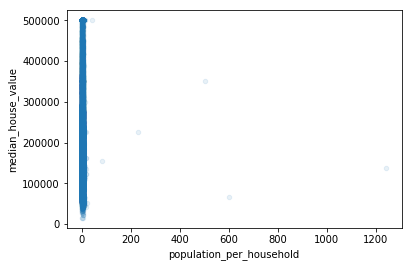

In [101]:
# just want to visualize that relationship for the houses per pop and the median price
visual_set.plot(kind='scatter',x='population_per_household',y='median_house_value',alpha=0.1)
plt.show()

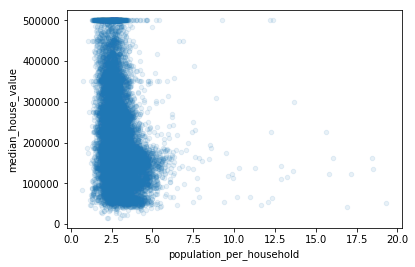

In [105]:
# hmmm quite a few outliers throwing this off, let me get rid of those...
visual_set[ visual_set['population_per_household'] < 20 ].plot(kind='scatter',x='population_per_household',y='median_house_value',alpha=0.1)
plt.show()

In [ ]:
# well there you go...there's just very little varience in pop per house hold
# across all of CA so it's not very useful..

In [79]:
# PREPARE DATA FOR ML ALGOS AND EXPLORE FEATURE CREATION

# making a test train splitter not using scikit-learn built in one
import numpy as np

def split_train_test(data, test_ratio):
    # shuffle the indices
    shuffled_indices = np.random.permutation( len(data) )
    test_set_size = int( len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    # return a train and test randomized set
    return data.iloc[train_indices], data.iloc[test_indices]

# problem with this is, everytime you load or refresh the data the 
# train/test set will be different, even if you use np.seed(1) the 
# data could shift at the source, so one solution from the text 
# book this case study is dervied is to use a hash function 
# on the data and keep particular hashes from data refresh to refresh
import hashlib

# here we use md5 hashing on some column of choice, and then
# test if it fits some critera on that last byte and always keep it
# if its under some fixed value that way we'll never get a test in the
# train set so long as the id_column of choice doesnt change for a row
def test_set_check(identifier, test_ratio, hash):
    return bytearray(hash( np.int64(identifier) ).digest())[-1] < 256*test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    # create a mask for selecting train/test set
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [65]:
# okay so we're goign to use the hashing method to 
# split a train and test but we need to create a
# unique id for each row.  What can we use to generate
# such a thing?  Well persumably the house isn't moving
# and no two houses share the same long-lat,
# so a combination of the long and lat should be able to
# make a unique id
housing_with_id = housing

housing_with_id['id'] = housing["longitude"]*1000 + housing["latitude"]

In [66]:
# check the index col appears
housing_with_id.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat,id
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,5.0,-122192.12
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,5.0,-122182.14
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,5.0,-122202.15
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,4.0,-122212.15
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,3.0,-122212.15


In [73]:
# use the index col to split it via hashing keep 80% for training
train, test = split_train_test_by_id(housing_with_id, 0.2,'id')

('max median_income: ', 15.0001)


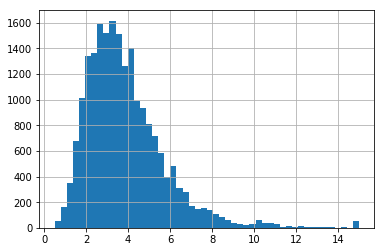

In [68]:
# so now that we've split the train and test set we have to be
# concerned that our test and train sets are representitive of
# the general population so that any ML method we use generalizes
# to unseen data well

# lets take a look at the median_income in the full data set
# and see how it compares to the train and test set
print('max median_income: ',np.max(housing['median_income']))
housing['median_income'].hist(bins=50)

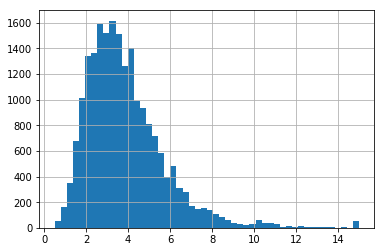

In [69]:
# looks pretty similar...but we'll need a quant test
train['median_income'].hist(bins=50)

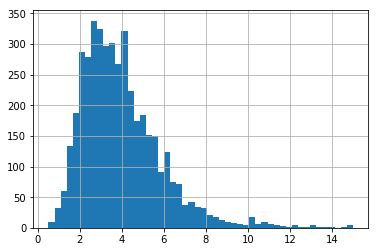

In [75]:
test['median_income'].hist(bins=50)

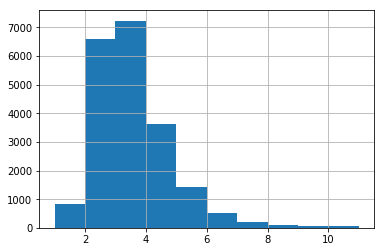

In [30]:
# okay so we're going to want to compare our distributions
# of the total pop vs the distros of the train and test set
# AND when we do K-Fold CV we're going to want to make sure
# each fold also has a similar distro, how can we accomplish that?

# well we can coarse grain (aggregate/lossy compress) the data
# so that its easy to compare and create K-Folds by creating a new
# categorical feature for some numerical feature. Here we'll follow
# the example and use the income category to accomplish this

# lets cateogorize the income values to see the shares into 10 bins
housing['income_cat'] = np.ceil( housing['median_income']/1.5 )

housing['income_cat'].hist()

# roll up anything over 5 into cat 5 since there's so little in the tail
housing['income_cat'].where( housing['income_cat'] < 5, 5.0, inplace=True)

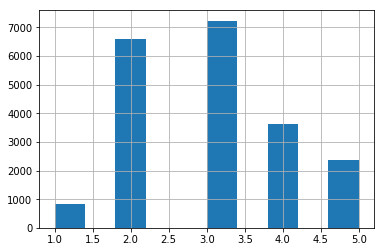

In [31]:
housing['income_cat'].hist()

In [32]:
# ok so now we need to make sure our test and train sets 
# have this same distrbution of incomes so that the train
# and test are representitive of the real world
from sklearn.model_selection import StratifiedShuffleSplit

In [33]:
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)

for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [86]:
# okay so lets compare this aggregation across the different split
# methods...
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

# random splitter
np.random.seed(42)
train_set, test_set = split_train_test(housing, 0.2)

# dataframe to hold the comparisons
compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()

compare_props

,Overall,Random,Stratified
1.0,0.039826,0.040213,0.039729
2.0,0.318847,0.324370,0.318798
3.0,0.350581,0.358527,0.350533
4.0,0.176308,0.167393,0.176357
5.0,0.114438,0.109496,0.114583


In [87]:
# looks like for the income cat we don't make a major 
# error using the randomized spliting, but just becasue
# it's slightly better we'll use the strat sets without
# the income_cat feature
for set_ in (strat_train_set,strat_test_set):
    set_.drop('income_cat',axis=1,inplace=True)

In [106]:
# DATA CLEANING AND PROCESSING STEP

# lets remove the target var
housing = strat_train_set.drop('median_house_value',axis=1)
# and store the target var in labels
housing_labels = strat_train_set['median_house_value'].copy()

In [109]:
# alright so now lets go back to looking at how much data is
# missing in this data set...
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 9 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16354 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
ocean_proximity       16512 non-null object
dtypes: float64(8), object(1)
memory usage: 1.3+ MB


In [111]:
# well it looks like our only missing set is from
# total_bedrooms, but if there was more missing data
# we could fill it with an Imputation method like median
# which is done below.  The only col that will be impacted
# will be the total_bedroom coln
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy='median')
# imputer doesn't handle categortical colns
housing_num = housing.drop('ocean_proximity',axis=1)

imputer.fit(housing_num)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

In [112]:
# holds the median values for each col
imputer.statistics_

array([ -118.51  ,    34.26  ,    29.    ,  2119.5   ,   433.    ,
        1164.    ,   408.    ,     3.5409])

In [118]:
# you can see its the same as this...
dict(zip(housing_num.columns.values,housing_num.median().values))

{'households': 408.0,
 'housing_median_age': 29.0,
 'latitude': 34.259999999999998,
 'longitude': -118.51000000000001,
 'median_income': 3.5408999999999997,
 'population': 1164.0,
 'total_bedrooms': 433.0,
 'total_rooms': 2119.5}

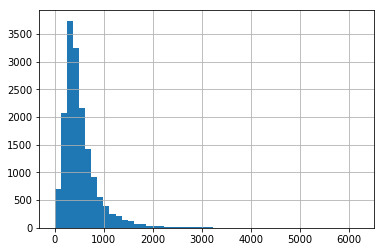

In [120]:
# because this is so asymetric it might be better to make
# an imputation by the mode or median in this case...but
# it shouldn't make too much of a difference in the value.
housing_num['total_bedrooms'].hist(bins=50)

In [121]:
# lets just apply the imputer
X = imputer.transform(housing_num)

In [123]:
# put it into the pandas DataFrame structure
housing_tr = pd.DataFrame(X, columns = housing_num.columns)

housing_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16512 entries, 0 to 16511
Data columns (total 8 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16512 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
dtypes: float64(8)
memory usage: 1.0 MB


In [125]:
# alright cool no missing data in that training set.

# lets look at our cateogrical coln
housing_cat = housing['ocean_proximity']
# check out a sample of the 10 first rows
housing_cat.head(10)

17606     <1H OCEAN
18632     <1H OCEAN
14650    NEAR OCEAN
3230         INLAND
3555      <1H OCEAN
19480        INLAND
8879      <1H OCEAN
13685        INLAND
4937      <1H OCEAN
4861      <1H OCEAN
Name: ocean_proximity, dtype: object

In [126]:
# alright well..seems valuable, lets encode these via OHE
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()

# first enumerate the unique words
housing_cat_encoded, housing_categories = housing_cat.factorize()
print housing_cat_encoded[:10]
print housing_categories

# now do a OHE on these enumerations
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))

housing_cat_1hot

[0 0 1 2 0 2 0 2 0 0]
Index([u'<1H OCEAN', u'NEAR OCEAN', u'INLAND', u'NEAR BAY', u'ISLAND'], dtype='object')


<16512x5 sparse matrix of type '<type 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [127]:
# lets just check it
housing_cat_1hot.toarray()

array([[ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  1.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.]])

In [128]:
# I guess scikit learn would handle all this already in CategoricalEncoder
# but lets just hammer it out

def CategoricalEncoder(housing_cat):
    encoder = OneHotEncoder()
    housing_cat_encoded, housing_categories = housing_cat.factorize()
    housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
    return housing_cat_1hot.toarray()

CategoricalEncoder(housing_cat)

array([[ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  1.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.]])

In [130]:
# alright well we're going to want this clean up, feature computation
# and encoding process automaticly done in a pipeline
# and to add some functions to the sklearn pipeline
# we have to put these computations into a class
# that has a fit and transform function
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, household_ix = 3,4,5,6

class CombinedAttributesAdder(BaseEstimator,TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    
    def fit(self, X, y=None):
        return self
    
    def transform(self,X,y=None):
        rooms_per_household = X[:,rooms_ix]/X[:,household_ix]
        population_per_household = X[:,population_ix]/X[:,household_ix]
    
        if self.add_bedrooms_per_room:
            bed_rooms_per_room = X[:,bedrooms_ix]/X[:,rooms_ix]
            return np.c_[X,rooms_per_household, population_per_household,bed_rooms_per_room]
        else:
            return np.c_[X,rooms_per_household, population_per_household]

In [159]:
# So lets also add in a standard scaler so that all
# the numerical features have mean 0 and variance 1
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# okay now lets setup this pipeline object so
# we can apply these data transformations easily
# to the numeric columns
num_pipeline = Pipeline([('imputer',Imputer(strategy='median')),
                        ('attribs_adder', CombinedAttributesAdder()),
                        ('std_scaler',StandardScaler())])

# apply the numeric transform pipeline to the housing numerical cols
housing_num_tr = num_pipeline.fit_transform(housing_num)

# lets take a look at the results
num_pl_cols = np.concatenate((housing_num.columns.values,np.array(['rooms_per_house','pop_per_house','bedrooms_per_room'])))
pd.DataFrame(housing_num_tr,columns=num_pl_cols).head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_house,pop_per_house,bedrooms_per_room
0,-1.156043,0.771950,0.743331,-0.493234,-0.445438,-0.636211,-0.420698,-0.614937,-0.312055,-0.086499,0.155318
1,-1.176025,0.659695,-1.165317,-0.908967,-1.036928,-0.998331,-1.022227,1.336459,0.217683,-0.033534,-0.836289
2,1.186849,-1.342183,0.186642,-0.313660,-0.153345,-0.433639,-0.093318,-0.532046,-0.465315,-0.092405,0.422200
3,-0.017068,0.313576,-0.290520,-0.362762,-0.396756,0.036041,-0.383436,-1.045566,-0.079661,0.089736,-0.196453
4,0.492474,-0.659299,-0.926736,1.856193,2.412211,2.724154,2.570975,-0.441437,-0.357834,-0.004194,0.269928


In [160]:
# looks good, okay now to add the OHE for the categorical features
# into the pipeline...
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder

# same thing as the OHE we have to add a class with
# fit and transform to use in pipelines
# this just selects certain rows in a data frame
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self,X):
        return X[self.attribute_names].values

# this does OHE for any cat colns
class CEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, sparse=False):
        self.sparse = sparse
    def fit(self, X, y=None):
        return self
    def transform(self,X):
        One_HE = OneHotEncoder()
        LE = LabelEncoder()
        X_encoded = LE.fit_transform(X)
        X_1hot = One_HE.fit_transform(X_encoded.reshape(-1,1))
        return X_1hot.toarray()

In [161]:
# lets just check this class works...
cat_encode = CEncoder()
housing_1h = cat_encode.fit_transform(housing_cat)

housing_1h

array([[ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.],
       ..., 
       [ 0.,  1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.]])

In [162]:
# looks good, ok let's get this OHE into the pipeline
num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

# okay so now we have to include in the numeric
# transformation the selection of the numeric colns
# as part of the pipeline...
num_pipeline = Pipeline([('selector',DataFrameSelector(num_attribs)),
                        ('imputer',Imputer(strategy='median')),
                        ('attribs_adder', CombinedAttributesAdder()),
                        ('std_scaler',StandardScaler())])

# and then the selection of the categorical colns
# and the transformation of these cat colns
cat_pipeline = Pipeline([('selector',DataFrameSelector(cat_attribs)),
                        ('cat_encoder',CEncoder())
                        ])

In [168]:
from sklearn.pipeline import FeatureUnion

# we can combine these pipelines together with 
# sklearn's FeatureUnion to give the final and full
# transformation/cleaning processing pipeline
full_pipeline = FeatureUnion(transformer_list = [('num_pipeline', num_pipeline),
                                                 ('cat_pipeline', cat_pipeline)])

In [169]:
# lets make sure this entire pipeline works
housing_prepared = full_pipeline.fit_transform(housing)

In [172]:
#check one row for good formating...
housing_prepared[0]

array([-1.15604281,  0.77194962,  0.74333089, -0.49323393, -0.44543821,
       -0.63621141, -0.42069842, -0.61493744, -0.31205452, -0.08649871,
        0.15531753,  1.        ,  0.        ,  0.        ,  0.        ,  0.        ])

In [173]:
# MACHINE LEARNING PART
from sklearn.linear_model import LinearRegression

# lets start it off with a linear model
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [191]:
# ok cool now lets see how it does for
# these samples...
some_data = housing_prepared[:5]
some_labels = housing_labels.values[:5]

In [192]:
print "predicitions: ", lin_reg.predict(some_data)
print "labels: ", some_labels

predicitions:  [ 210644.60459286  317768.80697211  210956.43331178   59218.98886849
  189747.55849879]
labels:  [ 286600.  340600.  196900.   46300.  254500.]


In [195]:
# and lets measure the accuracy of the linear model
# via the MSE
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.198198489219

In [193]:
# okay so it seems with the linear model
# we only have accuracy up to +-70k
# lets see how a tree regressor does...
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [198]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
np.sqrt(tree_mse)

0.0

In [199]:
# obviously it's over fitted, as is the nature
# of trees when you don't put any stopping condition
# in.  So how can we battle over fitting?
# we can use CV to tune models toward better
# generalization
from sklearn.model_selection import cross_val_score

# alright lets check out how this tree regressor
# works when we do 10 folds...
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                        scoring='neg_mean_squared_error', cv=10)

tree_rmse_scores = np.sqrt(-scores)

In [206]:
def display_scores(scores):
    sdf = pd.DataFrame({"scores":scores})
    print(sdf,sdf.describe())

display_scores(tree_rmse_scores)

(         scores
0  67676.035728
1  67381.922440
2  70214.554234
3  68305.207443
4  71301.734053
5  75578.051550
6  72569.678606
7  69993.335981
8  77010.703937
9  69579.437626,              scores
count     10.000000
mean   70961.066160
std     3243.391903
min    67381.922440
25%    68623.764989
50%    70103.945108
75%    72252.692468
max    77010.703937)


In [207]:
# so it looks like the tree regressor doesn't really
# do any better than the linear regessor...
# just for completeness let's compare to the linear
# regression CV scores
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                            scoring='neg_mean_squared_error', cv=10)

lin_rmse_score = np.sqrt(-lin_scores)
display_scores(lin_rmse_score)

(         scores
0  66782.738440
1  66960.118071
2  70347.952444
3  74739.570526
4  68031.133889
5  71193.841834
6  64969.630564
7  68281.611380
8  71552.915666
9  67665.100821,              scores
count     10.000000
mean   69052.461363
std     2879.437224
min    64969.630564
25%    67136.363758
50%    68156.372635
75%    70982.369487
max    74739.570526)


In [208]:
# So there you go, it doesn't look like doing
# any splits (like how a tree struct works)
# and using averages really does any better
# than just linear regression, we're going to
# have to pull out the bigger guns to get more
# accuracy. Lets check out a RandForest
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                            scoring='neg_mean_squared_error', cv=10)

forest_rmse_score = np.sqrt(-forest_scores)
display_scores(forest_rmse_score)

(         scores
0  51456.369703
1  49655.646859
2  53348.434636
3  54482.085254
4  51952.743560
5  54631.650279
6  50652.579264
7  50049.767302
8  55728.913089
9  52564.107188,              scores
count     10.000000
mean   52452.229713
std     2068.150218
min    49655.646859
25%    50853.526874
50%    52258.425374
75%    54198.672600
max    55728.913089)


In [249]:
# Hmmm, well it does do better we went from +-70k to +-53k
# accuracy, so we'll take it as a baseline...  

# MODEL FINE TUNING STEP 

# to search for the optimal parameters we could do 
# manual cuts of the data to see if there's some clustering
# that allows a regression tree to find some local ave
# values that make the accuracy increase by hand, 
# but since I don't know a priori which cuts to make
# lets perform some Random and Grid searchs in the
# hyperparameter space
from sklearn.model_selection import GridSearchCV

# setting up two grids to work on so we don't
# spend all day searching the hyperparam space...
param_grid = [{'n_estimators':[3,10,30],'max_features':[2,4,6,8]},
             {'bootstrap':[False],'n_estimators':[3,10],'max_features':[2,3,4]}]

forest_reg = RandomForestRegressor()

# we'll 5 fold CV to evaluate accuracy and MSE as our metric
grid_search = GridSearchCV(forest_reg, param_grid, cv = 5, scoring='neg_mean_squared_error')

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'n_estimators': [3, 10], 'max_features': [2, 3, 4], 'bootstrap': [False]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [211]:
# ok cool, so what did the GridSearch
# find for best params?
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [230]:
# lets also take a look at some of the 5foldCV-MSE
# values for the other hyper param combos to make
# sure there's a clear winner and not just a minor
# winner
cvres = grid_search.cv_results_

hyperMSE = []
for m,parm in zip(cvres['mean_test_score'],cvres['params']):
    hyperMSE.append([np.sqrt(-m), parm])

sorted(hyperMSE)

[[49880.803133955727, {'max_features': 6, 'n_estimators': 30}],
 [49992.383480669589, {'max_features': 8, 'n_estimators': 30}],
 [50489.165680979044, {'max_features': 4, 'n_estimators': 30}],
 [51654.041395564534,
  {'bootstrap': False, 'max_features': 4, 'n_estimators': 10}],
 [51949.958553000331, {'max_features': 8, 'n_estimators': 10}],
 [52016.654346319032, {'max_features': 6, 'n_estimators': 10}],
 [52653.135909892291,
  {'bootstrap': False, 'max_features': 3, 'n_estimators': 10}],
 [52904.520716002997, {'max_features': 4, 'n_estimators': 10}],
 [52983.745018652102, {'max_features': 2, 'n_estimators': 30}],
 [54834.768035742163,
  {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}],
 [55464.757999636066, {'max_features': 2, 'n_estimators': 10}],
 [58744.929311134598,
  {'bootstrap': False, 'max_features': 4, 'n_estimators': 3}],
 [59401.785085260875, {'max_features': 8, 'n_estimators': 3}],
 [60015.917696600933, {'max_features': 4, 'n_estimators': 3}],
 [60153.41939419940

In [231]:
# so we're at about +-50k with the best estimator, so we sqeezed out
# about 3k more accuracy from the grid search, and it appears
# that given the variance of the MSE score, its big improvement
# over the worst case params so we'll keep it, though all the top
# 3 hyper parameters performed similiarly. It's probably worth
# checking out the feature importances for the smallest model
# ie max_features = 4

# now let's gleem some insight into the RandForReg by looking
# at feature importance...
feature_importance = grid_search.best_estimator_.feature_importances_

In [238]:
# zip it with the names of the features
extra_attr = ['rooms_per_hhold','pop_per_hhold','bedrooms_per_room']
cats_attr = ['<1H OCEAN','INLAND','ISLAND','NEAR BAY','NEAR OCEAN']
attrs = list( housing.columns.values )+extra_attr+cats_attr

sorted( zip(feature_importance, attrs), reverse=True)

[(0.33418700398906082, 'median_income'),
 (0.13483314477663969, '<1H OCEAN'),
 (0.10710321930987061, 'rooms_per_hhold'),
 (0.080856321804086376, 'pop_per_hhold'),
 (0.07810021099435599, 'latitude'),
 (0.075958943333449977, 'longitude'),
 (0.058165639357674284, 'ocean_proximity'),
 (0.04285036797402527, 'housing_median_age'),
 (0.017774548316077231, 'total_rooms'),
 (0.017592299257180234, 'population'),
 (0.01622874264009945, 'households'),
 (0.016097166637260761, 'total_bedrooms'),
 (0.010077881068120954, 'bedrooms_per_room'),
 (0.0067948898486822566, 'NEAR BAY'),
 (0.0033202446106837297, 'ISLAND'),
 (5.9376082732416243e-05, 'INLAND')]

In [244]:
# hey, hey! look at that! population per house hold,
# which was hypthosised as a supply/demand metric
# is one of the top 4 most important features!
# so obiviously some split makes the pop per hhold
# valueable. Just as a complete check let's also
# test a support vector machine with some different
# kernels to see how it does...
from sklearn.svm import SVR
from scipy.stats import expon, reciprocal
from sklearn.model_selection import RandomizedSearchCV

support_vect_reg = SVR()

param_grid = {'kernel':['linear','rbf'],
              'C':reciprocal(20,2*10**5),
              'gamma':expon(scale=1.0)}

# we'll 5 fold CV to evaluate accuracy and MSE as our metric
rand_search = RandomizedSearchCV(support_vect_reg, 
                                 param_grid, 
                                 cv = 5, 
                                 scoring='neg_mean_squared_error',
                                 verbose = 2,
                                 n_jobs = -1)

rand_search.fit(housing_prepared,housing_labels)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] kernel=rbf, C=247.901657361, gamma=0.353422877727 ...............
[CV] kernel=rbf, C=247.901657361, gamma=0.353422877727 ...............
[CV] kernel=rbf, C=247.901657361, gamma=0.353422877727 ...............
[CV] kernel=rbf, C=247.901657361, gamma=0.353422877727 ...............
[CV]  kernel=rbf, C=247.901657361, gamma=0.353422877727, total=  17.4s
[CV] kernel=rbf, C=247.901657361, gamma=0.353422877727 ...............
[CV]  kernel=rbf, C=247.901657361, gamma=0.353422877727, total=  17.4s
[CV]  kernel=rbf, C=247.901657361, gamma=0.353422877727, total=  17.4s
[CV] kernel=rbf, C=22060.8252249, gamma=0.200747107233 ...............
[CV] kernel=rbf, C=22060.8252249, gamma=0.200747107233 ...............
[CV]  kernel=rbf, C=247.901657361, gamma=0.353422877727, total=  17.5s
[CV] kernel=rbf, C=22060.8252249, gamma=0.200747107233 ...............
[CV]  kernel=rbf, C=247.901657361, gamma=0.353422877727, total=  19.8s
[CV] kernel=rbf,

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.7min


[CV]  kernel=linear, C=4044.54266916, gamma=2.71648726549, total=  16.7s
[CV] kernel=linear, C=5223.88793921, gamma=0.414251986464 ............
[CV]  kernel=linear, C=4044.54266916, gamma=2.71648726549, total=  15.4s
[CV] kernel=linear, C=5223.88793921, gamma=0.414251986464 ............
[CV]  kernel=linear, C=5223.88793921, gamma=0.414251986464, total=  16.5s
[CV] kernel=linear, C=5223.88793921, gamma=0.414251986464 ............
[CV]  kernel=linear, C=5223.88793921, gamma=0.414251986464, total=  17.6s
[CV] kernel=rbf, C=4548.13788588, gamma=1.27986071322 ................
[CV]  kernel=linear, C=5223.88793921, gamma=0.414251986464, total=  17.0s
[CV] kernel=rbf, C=4548.13788588, gamma=1.27986071322 ................
[CV]  kernel=linear, C=5223.88793921, gamma=0.414251986464, total=  17.0s
[CV] kernel=rbf, C=4548.13788588, gamma=1.27986071322 ................
[CV]  kernel=linear, C=5223.88793921, gamma=0.414251986464, total=  16.5s
[CV] kernel=rbf, C=4548.13788588, gamma=1.27986071322 ....

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  5.2min finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=-1,
          param_distributions={'kernel': ['linear', 'rbf'], 'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a198609d0>, 'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x115002250>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=2)

In [246]:
# not any better than the linear regression...
np.sqrt(-rand_search.best_score_)

58103.8818414528

In [247]:
# lets just enumerate some of the results...
cvres = rand_search.cv_results_

hyperMSE = []
for m,parm in zip(cvres['mean_test_score'],cvres['params']):
    hyperMSE.append([np.sqrt(-m), parm])

sorted(hyperMSE)

[[58103.8818414528,
  {'C': 22060.825224939581, 'gamma': 0.20074710723339631, 'kernel': 'rbf'}],
 [70370.441487522403,
  {'C': 16752.483662707858, 'gamma': 0.35536182310996539, 'kernel': 'linear'}],
 [70374.33471222526,
  {'C': 5223.8879392087119, 'gamma': 0.41425198646386641, 'kernel': 'linear'}],
 [70379.713236344498,
  {'C': 4044.5426691583612, 'gamma': 2.7164872654912795, 'kernel': 'linear'}],
 [70385.617234597725,
  {'C': 3657.2740405324562, 'gamma': 2.318568410488838, 'kernel': 'linear'}],
 [70416.246907458379,
  {'C': 1713.882549325747, 'gamma': 1.3954136595953106, 'kernel': 'linear'}],
 [70750.447663214756,
  {'C': 260.50101084822023, 'gamma': 0.75609997315420663, 'kernel': 'linear'}],
 [70938.552246914463,
  {'C': 192.65436470591874, 'gamma': 1.1670957251023188, 'kernel': 'linear'}],
 [89342.976211007626,
  {'C': 4548.1378858784828, 'gamma': 1.2798607132186577, 'kernel': 'rbf'}],
 [99366.572458072216,
  {'C': 247.90165736112809, 'gamma': 0.35342287772658881, 'kernel': 'rbf'}]]

In [250]:
# well it seems with this data set and features we're using
# we could try gradient boosting or try to feature engineer
# some more but if we we're to use the random forest in prod
# how would we do?
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop('median_house_value', axis=1)
y_test = strat_test_set['median_house_value'].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test,final_predictions)
final_rmse = np.sqrt(final_mse)
print final_rmse

47530.975785


In [ ]:
# so ultimately with this set of data it looks like its possible
# to predict the median house price to an accuracy of about +-48k
# which isn't too good when the mean house price is around 200k.
# I think that the accuracy could likely be highly improved by
# looking for hyper localized features, like crime reports, 
# distances to public schools with school ratings, etc. things about
# the nieghborhoods.  As well I think information about average weather
# and climate could potentially improve the accuracy of this regressor.